In [1]:
import numpy as np
import pandas as pd
from datetime import date
import random
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as mtick
%matplotlib inline
import lifelines
pd.options.mode.chained_assignment = None

## Data preprocessing

In [2]:
#change datatypes for more efficient memory allocation
covid = pd.read_csv('covid19_data_22022021.csv',
        dtype=dict(sex='category',
                   age='str',
                   city='category',
                    province='category',
                    country='category',
                    geo_resolution='category',
                    date_onset_symptoms='category',
                    date_admission_hospital='category',
                    symptoms='str',
                    additional_information='str',
                    date_death_or_discharge='str',
                    travel_history_dates='str',
                    notes_for_discussion='str',
                    latitude=float,
                    longitude=float,
                    lives_in_Wuhan='category',
                    travel_history_location='category',
                    reported_market_exposure='category',
                    chronic_disease_binary='category',
                    chronic_disease='category',
                    source='category',
                    sequence_available='category',
                    outcome='str',
                    #sequence_available=bool,
                    location='category',
                    admin3='category',
                    admin2='category',
                    admin1='category',
                    country_new='category',
                    travel_history_binary='category',
                    data_moderator_initials='category'
                    ),)

In [3]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572679 entries, 0 to 572678
Data columns (total 33 columns):
ID                          572679 non-null object
age                         572679 non-null object
sex                         572679 non-null category
city                        524584 non-null category
province                    564785 non-null category
country                     572635 non-null category
latitude                    572679 non-null float64
longitude                   572679 non-null float64
geo_resolution              572679 non-null category
date_onset_symptoms         260311 non-null category
date_admission_hospital     9201 non-null category
date_confirmation           572410 non-null object
symptoms                    1565 non-null object
lives_in_Wuhan              1626 non-null category
travel_history_dates        2348 non-null object
travel_history_location     7816 non-null category
reported_market_exposure    402 non-null category
additional_in

In [4]:
#check values in the outcome column to see how the data will have to be preprocessed
list(covid["outcome"].unique())

['death',
 'discharge',
 nan,
 'discharged',
 'Discharged',
 'not hospitalized',
 'recovered',
 'recovering at home 03.03.2020',
 'released from quarantine',
 'severe',
 'stable',
 'died',
 'Death',
 'dead',
 'Symptoms only improved with cough. Currently hospitalized for follow-up.',
 'treated in an intensive care unit (14.02.2020)',
 'Alive',
 'Dead',
 'Recovered',
 'Stable',
 'Died',
 'Deceased',
 'stable condition',
 'Under treatment',
 'Receiving Treatment',
 'severe illness',
 'critical condition',
 'Hospitalized']

In [5]:
#extract the following columns for analysis
covid = covid[["age","sex","date_confirmation","chronic_disease_binary","date_death_or_discharge","outcome"]]
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572679 entries, 0 to 572678
Data columns (total 6 columns):
age                        572679 non-null object
sex                        572679 non-null category
date_confirmation          572410 non-null object
chronic_disease_binary     572679 non-null category
date_death_or_discharge    3094 non-null object
outcome                    33601 non-null object
dtypes: category(2), object(4)
memory usage: 18.6+ MB


In [6]:
covid.head().style

,age,sex,date_confirmation,chronic_disease_binary,date_death_or_discharge,outcome
0,78,male,21.02.2020,False,22.02.2020,death
1,61,female,14.02.2020,False,17.02.2020,discharge
2,66,male,07.02.2020,False,nan,nan
3,27,female,07.02.2020,False,nan,nan
4,17,male,07.02.2020,False,nan,nan


In [7]:
#convert age to numerical type
covid["age"] = covid["age"].str.split("-").str[0] #data has ages which are defined as a range xx-yy. I choose to take the first part of the split
np.sum(pd.to_numeric(covid["age"], errors="coerce").isnull()) 
#after this we are left with more than 20k null values. I think we can just get rid of them since we have ovrt 500k rows.

26259

In [8]:
covid["age"] = pd.to_numeric(covid["age"], errors="coerce")
delete = covid[covid["age"].isnull()].index #collect index of null rows
covid = covid.drop(delete)
covid.shape

(546420, 6)

In [9]:
#convert death related outcomes to 1 and others to 0
death_mask = covid["outcome"].isin(["death","died","dead","Death","Dead","Died","Deceased"])
covid["outcome"] = np.where(death_mask, True, False)

In [10]:
#check number of death outcomes
np.sum(covid["outcome"])

1368

In [11]:
#convert sex column of male and female to 1s and 0s
covid["sex"] = np.where(covid["sex"] == "male", 1, 0)

In [12]:
covid["sex"]

0         1
1         0
2         1
3         0
4         1
         ..
572674    0
572675    0
572676    0
572677    1
572678    1
Name: sex, Length: 546420, dtype: int32

In [13]:
#convert the censored NaN values to end of study date (22.02.2021)
covid["date_death_or_discharge"] = np.where(covid["date_death_or_discharge"].isnull(), "22.02.2021", covid["date_death_or_discharge"])

In [14]:
covid["date_death_or_discharge"]

0         22.02.2020
1         17.02.2020
2         22.02.2021
3         22.02.2021
4         22.02.2021
             ...    
572674    22.02.2021
572675    22.02.2021
572676    22.02.2021
572677    22.02.2021
572678    22.02.2021
Name: date_death_or_discharge, Length: 546420, dtype: object

In [15]:
covid["date_confirmation"]

0         21.02.2020
1         14.02.2020
2         07.02.2020
3         07.02.2020
4         07.02.2020
             ...    
572674    17.05.2020
572675    17.05.2020
572676    17.05.2020
572677    17.05.2020
572678    17.05.2020
Name: date_confirmation, Length: 546420, dtype: object

In [16]:
#check how many rows have null starting date. 
np.sum(covid["date_confirmation"].isnull())

269

In [17]:
#Being just a small number out of the whole we can just delete these rows
delete = covid[covid["date_confirmation"].isnull()].index #collect index of null rows
before = covid.shape[0]
covid = covid.drop(delete)
after = covid.shape[0]
before-after #appropriate number of rows was deleted!

269

In [18]:
#Now we must convert our date columns to actual date datatypes so we can compute our duration variable
np.sum(pd.to_datetime(covid["date_confirmation"], errors="coerce", format="%d.%m.%Y").isnull()) #Few of our dates unable to be converted. we can just get rid of these rows

5

In [19]:
#convert date_confirmation first to datetime
covid["date_confirmation"] = pd.to_datetime(covid["date_confirmation"], errors="coerce", format="%d.%m.%Y")

In [20]:
covid.shape

(546151, 6)

In [21]:
delete = covid[covid["date_confirmation"].isnull()].index
covid = covid.drop(delete)
covid.shape #we can see that 5 rows were only dropped as wanted

(546146, 6)

In [22]:
np.sum(pd.to_datetime(covid["date_death_or_discharge"], errors="coerce", format="%d.%m.%Y").isnull()) #1 null in second date column

1

In [23]:
#convert date_death_or_discharged to datetime
covid["date_death_or_discharge"] = pd.to_datetime(covid["date_death_or_discharge"], errors="coerce", format="%d.%m.%Y")

In [24]:
#create a new column where we have the duration = date_death_or_discharge minus date_confirmation
covid["DURATION"] = abs(covid["date_death_or_discharge"] - covid["date_confirmation"]).dt.days #capitalized column name to distinguish between original and created column
covid["DURATION"].describe() #Choose days for duration since there are not that huge numbers (max is 407 days)

count    546145.000000
mean        300.657203
std          33.118799
min           0.000000
25%         279.000000
50%         301.000000
75%         323.000000
max         407.000000
Name: DURATION, dtype: float64

In [25]:
covid.head().style

,age,sex,date_confirmation,chronic_disease_binary,date_death_or_discharge,outcome,DURATION
0,78,1,2020-02-21 00:00:00,False,2020-02-22 00:00:00,True,1
1,61,0,2020-02-14 00:00:00,False,2020-02-17 00:00:00,False,3
2,66,1,2020-02-07 00:00:00,False,2021-02-22 00:00:00,False,381
3,27,0,2020-02-07 00:00:00,False,2021-02-22 00:00:00,False,381
4,17,1,2020-02-07 00:00:00,False,2021-02-22 00:00:00,False,381


In [26]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 546146 entries, 0 to 572678
Data columns (total 7 columns):
age                        546146 non-null float64
sex                        546146 non-null int32
date_confirmation          546146 non-null datetime64[ns]
chronic_disease_binary     546146 non-null category
date_death_or_discharge    546145 non-null datetime64[ns]
outcome                    546146 non-null bool
DURATION                   546145 non-null float64
dtypes: bool(1), category(1), datetime64[ns](2), float64(2), int32(1)
memory usage: 24.0 MB


In [27]:
delete = covid[covid["DURATION"].isnull()].index
covid = covid.drop(delete)
covid.shape

(546145, 7)

In [28]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 546145 entries, 0 to 572678
Data columns (total 7 columns):
age                        546145 non-null float64
sex                        546145 non-null int32
date_confirmation          546145 non-null datetime64[ns]
chronic_disease_binary     546145 non-null category
date_death_or_discharge    546145 non-null datetime64[ns]
outcome                    546145 non-null bool
DURATION                   546145 non-null float64
dtypes: bool(1), category(1), datetime64[ns](2), float64(2), int32(1)
memory usage: 24.0 MB


In [29]:
np.sum(covid["outcome"])

1326

In [30]:
covid["chronic_disease_binary"] = np.where(covid["chronic_disease_binary"] == "True", True, False)
covid["chronic_disease_binary"]

0         False
1         False
2         False
3         False
4         False
          ...  
572674    False
572675    False
572676    False
572677    False
572678    False
Name: chronic_disease_binary, Length: 546145, dtype: bool

## Kaplan Meier model

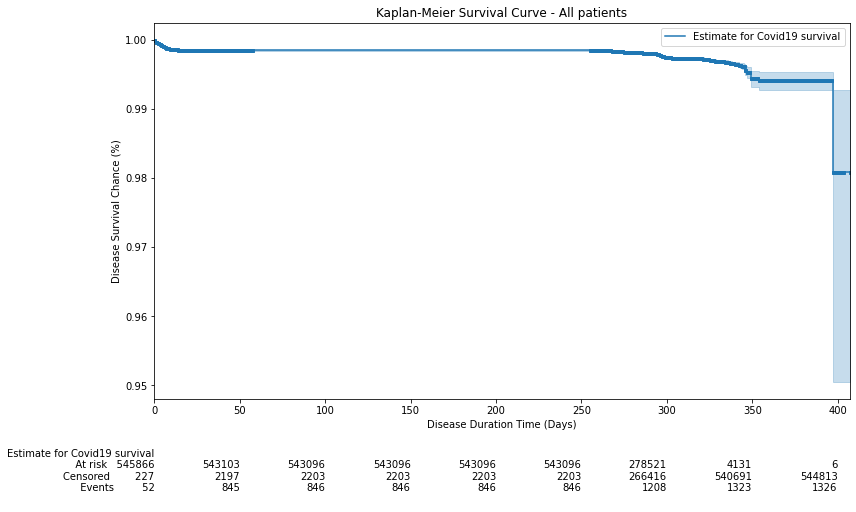

In [31]:
days = covid['DURATION'].values
died = covid['outcome'].values
kmf = lifelines.KaplanMeierFitter()
kmf.fit(days, event_observed=died, label='Estimate for Covid19 survival')

# plotting kmf curve
fig, ax = plt.subplots(figsize=(12,7))
kmf.plot(ax=ax,show_censors=True, censor_styles={'ms': 3, 'marker': 's'},at_risk_counts=True)
ax.set_title('Kaplan-Meier Survival Curve - All patients')
ax.set_xlabel('Disease Duration Time (Days)')
ax.set_ylabel('Disease Survival Chance (%)')
plt.show()

In [32]:
# function for creating Kaplan-Meier curve plots segmented
# by categorical variables
def plot_categorical_survival(feature, t='DURATION', event= 'outcome', df=covid, ax=None):
    for cat in df[feature].unique():
        idx = df[feature] == cat
        kmf = lifelines.KaplanMeierFitter()
        kmf.fit(df[idx][t], event_observed=df[idx][event], label=cat)
        kmf.plot(ax=ax, label=cat)

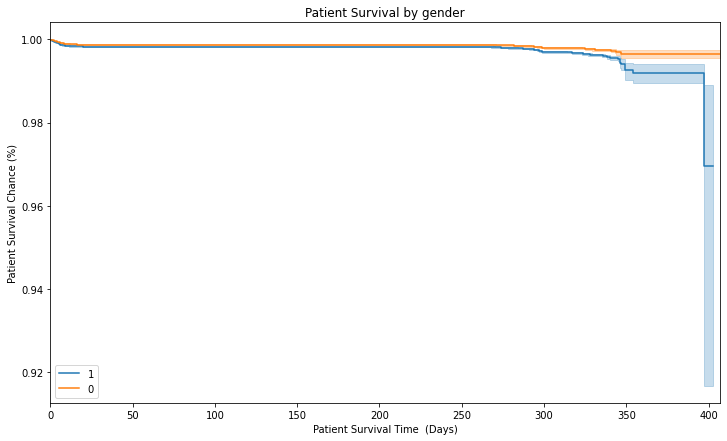

In [33]:
#plot by gender
fig_gen, ax_gen = plt.subplots(figsize=(12,7))
plot_categorical_survival(feature='sex', ax=ax_gen)
ax_gen.set_title('Patient Survival by gender')
ax_gen.set_xlabel('Patient Survival Time  (Days)')
ax_gen.set_ylabel('Patient Survival Chance (%)')
plt.show()

In [34]:
male = (covid["sex"] == 1)
T = covid["DURATION"]
E = covid["outcome"]
kmf.fit(T[male], event_observed=E[male])

from lifelines.statistics import logrank_test

covid_gender_results = logrank_test(T[male], T[~male], E[male], E[~male], alpha=.99)
covid_gender_results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          52.05 <0.005     40.75

In [35]:
#create new column for three different age groups
covid["AGE_GROUP"] = pd.cut(covid["age"], bins=[-1,39,64,9999], labels=["young","middle","old"])

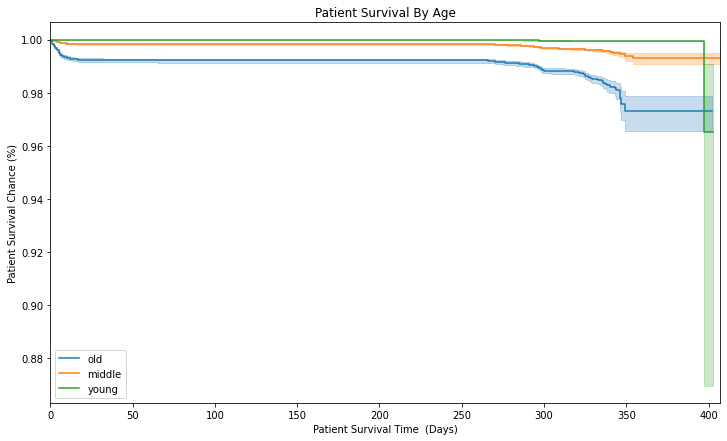

In [36]:
fig_agrp, ax_agrp = plt.subplots(figsize=(12,7))
plot_categorical_survival(feature='AGE_GROUP', ax=ax_agrp)
ax_agrp.set_title('Patient Survival By Age')
ax_agrp.set_xlabel('Patient Survival Time  (Days)')
ax_agrp.set_ylabel('Patient Survival Chance (%)')
plt.show()

In [37]:
old = (covid["AGE_GROUP"] == "old")
T = covid["DURATION"]
E = covid["outcome"]
kmf.fit(T[old], event_observed=E[old])

covid_age_results = logrank_test(T[old], T[~old], E[old], E[~old], alpha=.99)
covid_age_results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
        2113.92 <0.005       inf

## EDA

In [38]:
covid.describe()

,age,sex,DURATION
count,546145.000000,546145.000000,546145.000000
mean,40.607816,0.537742,300.657203
std,18.582749,0.498574,33.118799
min,0.000000,0.000000,0.000000
25%,29.000000,0.000000,279.000000
50%,36.000000,1.000000,301.000000
75%,55.000000,1.000000,323.000000
max,121.000000,1.000000,407.000000


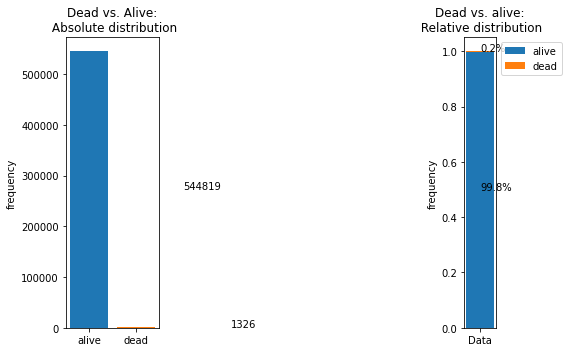

In [39]:
# plot dead vs. alive 
keys, counts = np.unique(covid.outcome, return_counts=True)
counts_norm = counts/counts.sum()

fig = plt.figure(figsize=(8, 5)) #specify figure size
gs = gridspec.GridSpec(1, 2, width_ratios=[3,1]) #specify relative size of left and right plot

#Absolute values
ax0 = plt.subplot(gs[0])
ax0 = plt.bar(['alive', 'dead'], counts, color=['#1f77b4','#ff7f0e']) #left bar plot
ax0 = plt.title('Dead vs. Alive:\n Absolute distribution') 
ax0 = plt.ylabel('frequency')
ax0 = plt.text(['Alive'], counts[0]/2, counts[0]) #add text box with count of alive patients
ax0 = plt.text(['Dead'], counts[1]/2, counts[1]) #add text box with count of dead patients

#Normalized values
ax1 = plt.subplot(gs[1])
ax1 = plt.bar(['Data'], [counts_norm[0]], label='alive')
ax1 = plt.bar(['Data'], [counts_norm[1]], bottom=counts_norm[0], label='dead')
ax1 = plt.legend(bbox_to_anchor=(1, 1))
ax1 = plt.title('Dead vs. alive:\n Relative distribution')
ax1 = plt.ylabel('frequency')
ax1 = plt.text(['Data'],counts_norm[0]/2, '{}%'.format((counts_norm[0]*100).round(1)))
ax1 = plt.text(['Data'],(counts_norm[1]/2)+counts_norm[0], '{}%'.format((counts_norm[1]*100).round(1)))

plt.tight_layout()
plt.show()

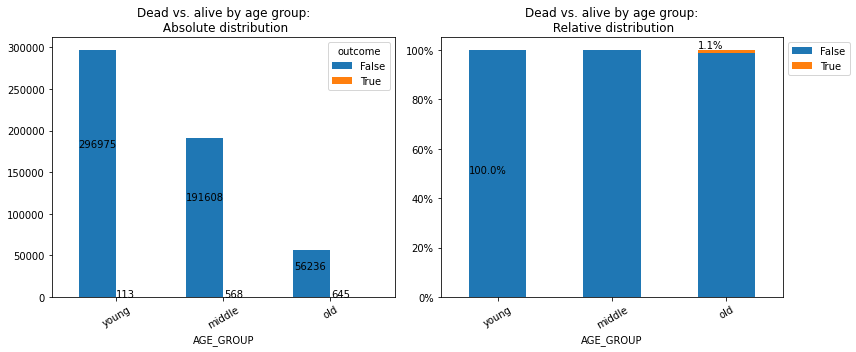

In [40]:
#deaths by age group
fig = plt.figure(figsize=(12, 5)) #specify figure size

#Absolute distribution
plt.subplot(1, 2, 1)
ax1 = covid.groupby(['AGE_GROUP', 'outcome'])['outcome'].count().unstack().plot.bar(rot=30, ax=plt.gca(), width=0.7)
plt.title('Dead vs. alive by age group:\n Absolute distribution') 
#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 0.605))

#Relative distribution
plt.subplot(1, 2, 2)
ax2 = covid.groupby(['AGE_GROUP','outcome'])['outcome'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=30, ax=plt.gca())
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Dead vs. alive by age group:\n Relative distribution') 
#plot bar labels
for p, q in zip(ax2.patches[0:5], ax2.patches[5:10]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x(), p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x(), q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

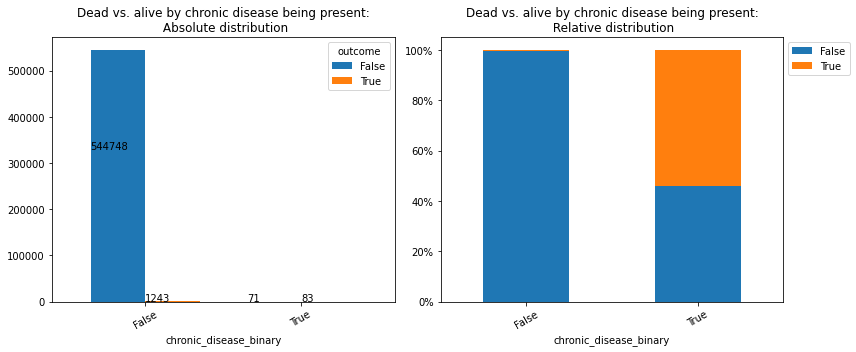

In [41]:
#deaths vs. chronic disease being present or not
fig = plt.figure(figsize=(12, 5)) #specify figure size

#Absolute distribution
plt.subplot(1, 2, 1)
ax1 = covid.groupby(['chronic_disease_binary', 'outcome'])['outcome'].count().unstack().plot.bar(rot=30, ax=plt.gca(), width=0.7)
plt.title('Dead vs. alive by chronic disease being present:\n Absolute distribution') 
#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 0.605))

#Relative distribution
plt.subplot(1, 2, 2)
ax2 = covid.groupby(['chronic_disease_binary','outcome'])['outcome'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=30, ax=plt.gca())
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Dead vs. alive by chronic disease being present:\n Relative distribution') 
#plot bar labels
for p, q in zip(ax2.patches[0:5], ax2.patches[5:10]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x(), p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x(), q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

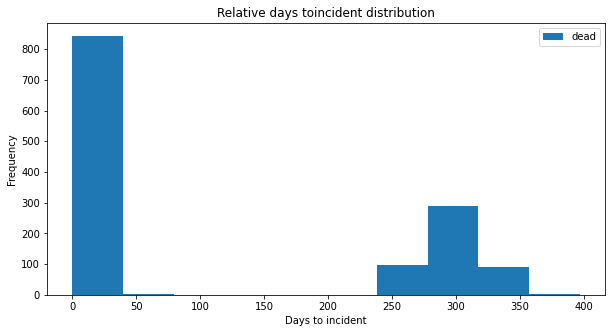

In [42]:
ax = covid['DURATION'].loc[covid['outcome'] == 1].plot.hist(bins=10, label='dead', figsize = (10,5))
ax.set_xlabel('Days to incident')
ax.set_title('Relative days toincident distribution')
ax.legend();

## Cox Regression

In [43]:
covid = pd.get_dummies(covid, drop_first = True, columns=["AGE_GROUP"]) #one hot encode the string variables

In [44]:
covid.head()

,age,sex,date_confirmation,chronic_disease_binary,date_death_or_discharge,outcome,DURATION,AGE_GROUP_middle,AGE_GROUP_old
0,78.0,1,2020-02-21,False,2020-02-22,True,1.0,0,1
1,61.0,0,2020-02-14,False,2020-02-17,False,3.0,1,0
2,66.0,1,2020-02-07,False,2021-02-22,False,381.0,0,1
3,27.0,0,2020-02-07,False,2021-02-22,False,381.0,0,0
4,17.0,1,2020-02-07,False,2021-02-22,False,381.0,0,0


In [45]:
#drop columns to avoid collinearity
dropped =  ["date_confirmation", "date_death_or_discharge", "age", "chronic_disease_binary", "AGE_GROUP_middle", "AGE_GROUP_old"]
covid2 = covid.drop(dropped, axis=1)

In [46]:
covid2.head().style

,sex,outcome,DURATION
0,1,True,1
1,0,False,3
2,1,False,381
3,0,False,381
4,1,False,381


In [47]:
from sklearn.model_selection import train_test_split
random.seed(10)

covid_train, covid_test = train_test_split(covid2, test_size=0.3)
covid_cph = lifelines.CoxPHFitter()
covid_cph.fit(covid_train, duration_col="DURATION", event_col="outcome", show_progress=False)
covid_cph.print_summary()


<lifelines.CoxPHFitter: fitted with 382301 total observations, 381369 right-censored observations>
             duration col = 'DURATION'
                event col = 'outcome'
      baseline estimation = breslow
   number of observations = 382301
number of events observed = 932
   partial log-likelihood = -11704.17
         time fit was run = 2021-04-24 13:25:33 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
sex         0.40       1.49       0.07             0.27             0.53                 1.31                 1.70

             z      p   -log2(p)
covariate                       
sex       5.90 <0.005      28.06
---
Concordance = 0.54
Partial AIC = 23410.35
log-likelihood ratio test = 35.83 on 1 df
-log2(p) of ll-ratio test = 28.79

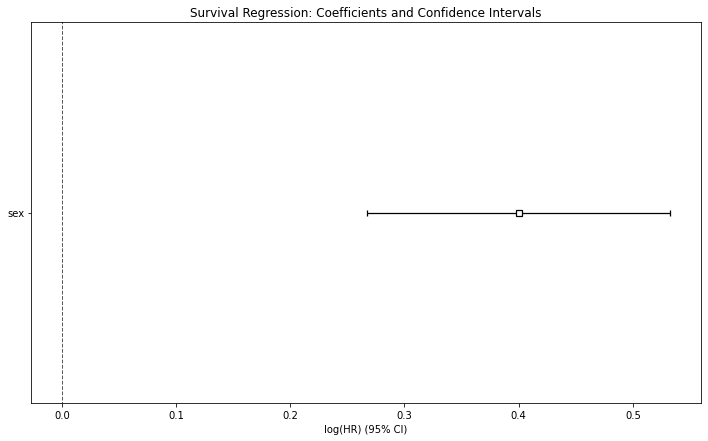

In [48]:
# plotting coefficients
fig_coef, ax_coef = plt.subplots(figsize=(12,7))
ax_coef.set_title('Survival Regression: Coefficients and Confidence Intervals')
covid_cph.plot(ax=ax_coef);

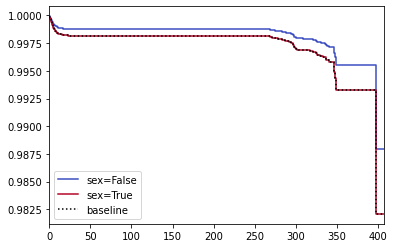

In [49]:
# check covariate group 
covid_cph.plot_partial_effects_on_outcome('sex', [False,True], cmap='coolwarm')

In [50]:
dropped =  ["date_confirmation", "date_death_or_discharge", "age", "chronic_disease_binary"]
covid3 = covid.drop(dropped, axis=1)

In [ ]:
strata_variables = ["sex"]
strata_covid_cph = lifelines.CoxPHFitter()


strata_covid_cph.fit(covid3, duration_col='DURATION', event_col='outcome', show_progress=False, strata=strata_variables)
strata_covid_cph.print_summary()
strata_covid_cph.check_assumptions(covid3, p_value_threshold=0.05, show_plots=True)

<lifelines.CoxPHFitter: fitted with 546145 total observations, 544819 right-censored observations>
             duration col = 'DURATION'
                event col = 'outcome'
                   strata = ['sex']
      baseline estimation = breslow
   number of observations = 546145
number of events observed = 1326
   partial log-likelihood = -15315.34
         time fit was run = 2021-04-24 13:25:41 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                
AGE_GROUP_middle   2.07       7.94       0.10             1.87             2.27                 6.49                 9.72
AGE_GROUP_old      3.43      30.95       0.10             3.23             3.63                25.34                37.80

                     z      p   -log2(p)
covariate                               
AGE_GROUP_middle 20.11 <0.005     296.24
AGE_GROUP_old    33.64 <0.005     821.72
---
Concordance = 0.80
Partial AIC = 30634.69
log-likelihood ratio test = 1831.88 on 2 df
-log2(p) of ll-ratio test = inf